In [1]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import utm

In [2]:
# get network from place name and create undirected graph

city = ox.graph.graph_from_place('Jonzieux',network_type='walk')
city = city.to_undirected()
city_projected = ox.project_graph(city).to_undirected()

# eulerize and get circuit

city_eulerized = nx.eulerize(city)
circuit = list(nx.eulerian_circuit(city_eulerized))

In [3]:
# get coordinates of path and total length

original_nodes,original_edges = ox.graph_to_gdfs(city)
origin = original_nodes.iloc[0]
origin = list(origin['geometry'].coords)

index = original_edges.index
lon_lat_path = origin
total_length = 0
step_dic = {edge:0 for edge in circuit}

for edge in circuit:
    
    is_edge = [set(edge).issubset(i) for i in index]    
    gdf_edges = original_edges[is_edge]
    n_edges = len(gdf_edges)
    geom = gdf_edges['geometry']    
    step = step_dic[edge]
    coords = list(geom.iloc[step].coords)

    if lon_lat_path[-1] == coords[0]:
        lon_lat_path.extend(coords)

    else:
        lon_lat_path.extend(coords[::-1])

    total_length += gdf_edges['length'].iloc[step]
        
    if n_edges > 1:
        step_dic[edge] = (step+1) % n_edges
                    
x,y = [],[]

for point in lon_lat_path:
    x_value,y_value,zn,zl = utm.from_latlon(*point[::-1])
    x.append(x_value),y.append(y_value)

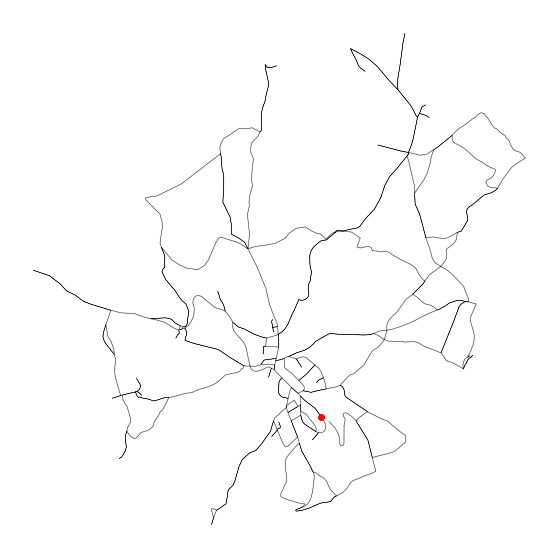

In [4]:
# create gif

fig,ax = plt.subplots(figsize=(10,10))

for position in ['right','left','top','bottom']:
    ax.spines[position].set_visible(False)
    
ax.tick_params(axis='both',which='both',left=False,bottom=False,
                labelleft=False,labelbottom=False)

bg_edges = ox.graph_to_gdfs(city_projected,nodes=False)["geometry"] # this is not ideal, edges are projected twice
# first automatically (city_projected) then manually (lat_lon_path)
bg_edges.plot(ax=ax,color='grey',alpha=0.2)
    
line, = ax.plot([],[],color='black',lw=0.4)
point, = ax.plot([],[],'ro',ls='none')
p = 200
ax.set_xlim([min(x)-p,max(x)+p])
ax.set_ylim([min(y)-p,max(y)+p])

def animate(k):
    i = min(k,len(x))
    line.set_data(x[:i],y[:i])
    point.set_data(x[i],y[i])
    return(line,point)

animation = FuncAnimation(fig=fig,func=animate,frames=range(len(x)),interval=50,blit=True)
animation.save(filename="./animation.gif",dpi=50,fps=40)